In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

# our module
from preprocess import *

In [2]:
df = sr_data_reader()

### language features

In [3]:
# before we try to learn good values for theta 
# we need to construct x

# x = information a students history learning a certain word

df.iloc[0,:]

p_recall                                       0.9999
timestamp                         2013-02-28 20:16:14
user_id                                         u:mKI
learning_language                                  es
ui_language                                        en
lexeme_id            e8578c557b3989f9efbc424f9430091d
lexeme_string          come/comer<vblex><pri><p3><sg>
history_seen                                       15
history_correct                                    15
session_seen                                        1
session_correct                                     1
delta_days                                        0.0
h                                                0.01
Name: 0, dtype: object

In [4]:
# (df['p_recall'] == (df['session_correct'])/(df['session_seen'])).sum() == df.shape[0]

# p_recall is the ratio of session_correct/session_seen

# p_recall is "y" "ground truth"

# predicted_p_recall is "y_hat" "prediction"

# error(p_recall,predicted_p_recall) <- we want this to be as small as possible

# if we can very reliably predict p_recall, what is the value of this in real-life terms?


In [5]:
# get parts of speech

def lexeme_df(filename):

    import re
    df_single_col = pd.read_csv(filename, delimiter='\t', header=None, names=['line'])

    def split_line(line):
        parts = re.split(r'\s+', line, maxsplit=2)
        if len(parts) == 3:
            return parts
        return [None, None, None]

    df_split = df_single_col['line'].apply(split_line)
    df = pd.DataFrame(df_split.tolist(), columns=['lexeme', 'category', 'meaning'])

    return df

In [6]:
lexemes = lexeme_df('lexeme_reference.txt')
lexemes.head()

,lexeme,category,meaning
0,aa,animacy,Animate
1,acr,adjective,Acronym
2,adj,POS,Adjective
3,adv,POS,Adverb
4,al,other,Other (altre)


In [7]:
lexemes['lexeme'].nunique()

92

In [8]:
# one-hot encoding
# dummy variables / indicator variables

# df.loc[0,"lexeme_string"]

"<det><def><nt><sg><nom>"

# det, df, nt, sg, nom + 87 more 

# word | det | def | nt | sg | nom | ...
# das  |  1  | 1   | 1  | 1  |  1  | 0 ...



# look for the first <, remove everything to the left
# then remove <, >

# 

def extract_right_of_lt(text):
    import re
    match = re.search(r'<(.*)', text)
    return match.group(1) if match else ''




In [9]:
df['lexeme_string'] = df['lexeme_string'].apply(extract_right_of_lt)
df['lexeme_string'] = df['lexeme_string'].str.replace("<"," ")
df['lexeme_string'] = df['lexeme_string'].str.replace(">","")
df['lexeme_string'] = df['lexeme_string'].str.replace("*","")
df['lexeme_string'] = df['lexeme_string'].str.replace("/","")
df['lexeme_string']

0        vblex pri p3 sg
1                   n sg
2        prn tn p2 mf sg
3                 n f sg
4                 n m sg
              ...       
12867               n pl
12868             n m sg
12869               n sg
12870               n sg
12871                adv
Name: lexeme_string, Length: 12872, dtype: object

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), binary=True)
vectorized_words = vectorizer.fit_transform(df['lexeme_string'])
vectorized_df = pd.DataFrame(vectorized_words.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

/Users/arad/mambaforge/envs/sr/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [11]:
# no longer optimizing this for now,
# i want to talk about specifying the model
# we'll return to this

vectorized_df.head()

,@adv:en_general,@adv:peut_etre,@adv:por_favor,@adv:por_supuesto,@adv:s_il_te_plait,@adv:s_il_vous_plait,@cnj:des_que,@common_phrases:a_demain,@common_phrases:a_plus,@common_phrases:a_plus_tard,...,subj,suff,sw,tn,vaux,vbdo,vbhaver,vblex,vbmod,vbser
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
vectorized_df.sum().sort_values()

@adv:en_general       1
sfmamma               1
sfmaman               1
sfmagnifique          1
sfmaglione            1
                   ... 
vblex              2238
pl                 2296
m                  2350
n                  5578
sg                 7549
Length: 461, dtype: int64

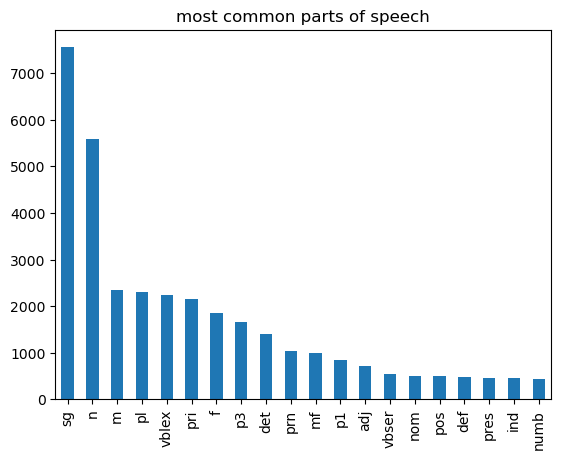

In [13]:
# curious about most common parts of speech.
# how different parts of speech correspond to rate of correct responses

#
vectorized_df.sum().sort_values(ascending=False)[0:20].plot(kind = "bar",title="most common parts of speech")
plt.show()


In [14]:
# p_recall 

df = pd.concat([df,vectorized_df],axis=1)
df.shape

(12872, 474)

In [15]:
df.drop(columns = ['lexeme_string'],inplace=True)

In [16]:
grp_by_columns = list(df.columns[~df.columns.isin(['p_recall','delta','user_id','timestamp',"history_seen", "history_correct", "session_seen",  "session_correct"])])

"""
select avg(p_recall)
from df
group by var1

select avg(p_recall)
from df
group by var2

...

select avg(p_recall)
from df
group by varn

"""

"""

select avg(p_recall)
from df
group by var1, ..., varn

"""

# 1515 binary vectors (one for each part of speech)

# 0 avg(p_recall)
# 1 avg(p_recall)

# df.drop(columns = grp_by_columns).mean(axis=1)



# df[grp_by_columns].mean(axis = 1)

list_of_recall_variation_by_column = []

for col in grp_by_columns:

    variation_of_means = df.groupby(col)['p_recall'].mean().std()

    variation_dict = {"column_name":col,
                      "variation_of_means":variation_of_means}

    list_of_recall_variation_by_column.append(variation_dict)

recall_variation_by_column = pd.DataFrame(list_of_recall_variation_by_column)
    
# col_name, std of group means

#### fitting

In [17]:
from spaced_repetition import *
import torch.optim as optim


### Leitner

In [18]:
from leitner import *

leitner = leitner_model()
leitner_x, leitner_delta = leitner_data(df)

leitner_predicted_p_recall = leitner.predict(leitner_x,leitner_delta)

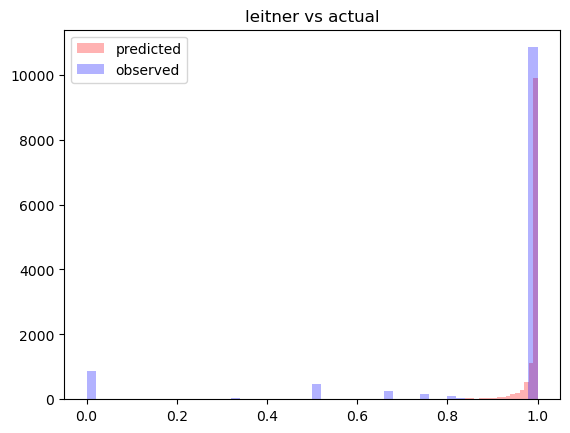

In [19]:
def training_run_evaluator(model_name,y_true,y_pred):
    """we should add more model eval stuff to this"""
    
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().numpy()
        
    fig = plt.figure()
    plt.hist(y_pred.detach().numpy(),color = "red",alpha = .3,label = 'predicted',bins=50)
    plt.hist(y_true,color = "blue",alpha = .3,label = 'observed',bins = 50)
    plt.legend()
    plt.title(f"{model_name} vs actual")
    
    # fig = plt.gcf()
    # plt.close(fig)

    return fig


fig = training_run_evaluator("leitner",df['p_recall'],leitner_predicted_p_recall)

### Half-Life Regression HLR

In [20]:
import torch.optim as optim

input_dim = 2 # number of features (history_seen, history_correct)
learning_rate = 0.001 # hyperparameter that we give the optimizer
num_epochs = 100 # 1 epoch = a single forward pass of all data  
alpha = 0.0 # controls the influence of the half-life term
lambda_reg = 0.0 # controls the influence of the penalty/regularization term

hlr = SpacedRepetition(input_dim, alpha, lambda_reg)
optimizer = optim.Adam(hlr.parameters(), lr=learning_rate) # default learning rate for adam is .001


In [21]:
from utils import mape_rmse_rsq

In [22]:
dataloader = sr_data_loader(df,batch_size = 12000)

In [23]:
metrics = {"epoch":[],
           "batch": [],
           "batch_training_loss":[],
           "batch_training_mape":[],
           "batch_training_rmse":[],
           "batch_training_rsq":[]}

for epoch in range(num_epochs):
    hlr.train()
    for batch_idx, (batch_x, batch_p, batch_h, batch_delta) in enumerate(dataloader, start=1):

        print(f"training in epoch:{epoch} -- batch:{batch_idx}")
        
        h_hat = hlr.half_life(batch_x)
        p_hat = hlr.p_recall(h_hat, batch_delta)
        
        batch_loss = hlr.loss(batch_p, p_hat, batch_h, h_hat)
        
        # metrics
        batch_mape, batch_rmse, batch_rsq = mape_rmse_rsq(batch_p,p_hat)
        
        metrics['epoch'].append(epoch + 1)
        metrics['batch'].append(batch_idx)
        metrics['batch_training_loss'].append(batch_loss.item())
        metrics['batch_training_mape'].append(batch_mape.detach().cpu().item())
        metrics['batch_training_rmse'].append(batch_rmse.detach().cpu().item())
        metrics['batch_training_rsq'].append(batch_rsq.detach().cpu().item())
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

training in epoch:0 -- batch:1
training in epoch:0 -- batch:2
training in epoch:1 -- batch:1
training in epoch:1 -- batch:2
training in epoch:2 -- batch:1
training in epoch:2 -- batch:2
training in epoch:3 -- batch:1
training in epoch:3 -- batch:2
training in epoch:4 -- batch:1
training in epoch:4 -- batch:2
training in epoch:5 -- batch:1
training in epoch:5 -- batch:2
training in epoch:6 -- batch:1
training in epoch:6 -- batch:2
training in epoch:7 -- batch:1
training in epoch:7 -- batch:2
training in epoch:8 -- batch:1
training in epoch:8 -- batch:2
training in epoch:9 -- batch:1
training in epoch:9 -- batch:2
training in epoch:10 -- batch:1
training in epoch:10 -- batch:2
training in epoch:11 -- batch:1
training in epoch:11 -- batch:2
training in epoch:12 -- batch:1
training in epoch:12 -- batch:2
training in epoch:13 -- batch:1
training in epoch:13 -- batch:2
training in epoch:14 -- batch:1
training in epoch:14 -- batch:2
training in epoch:15 -- batch:1
training in epoch:15 -- batc

In [24]:
batch_metrics_df = pd.DataFrame(metrics) # 1000 records, very granular

# aggregate to the epoch (1 epoch is equivalent to 10 batches in our case. it means all data has passed through the model)

epoch_metrics_df = batch_metrics_df.groupby('epoch').mean()



In [25]:
epoch_metrics_df.columns

Index(['batch', 'batch_training_loss', 'batch_training_mape',
       'batch_training_rmse', 'batch_training_rsq'],
      dtype='object')

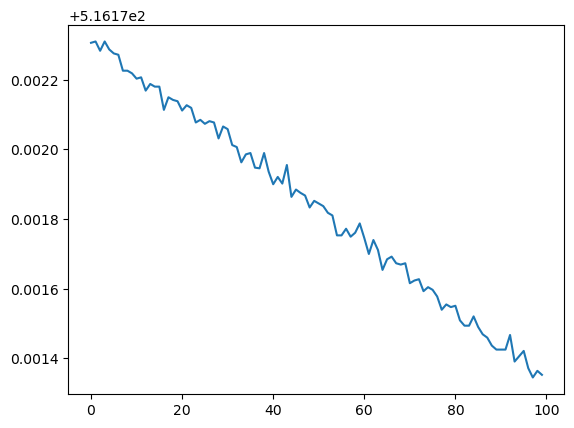

In [26]:
plt.plot(range(num_epochs), epoch_metrics_df['batch_training_loss'])
# plt.ylim(0,losses[0])


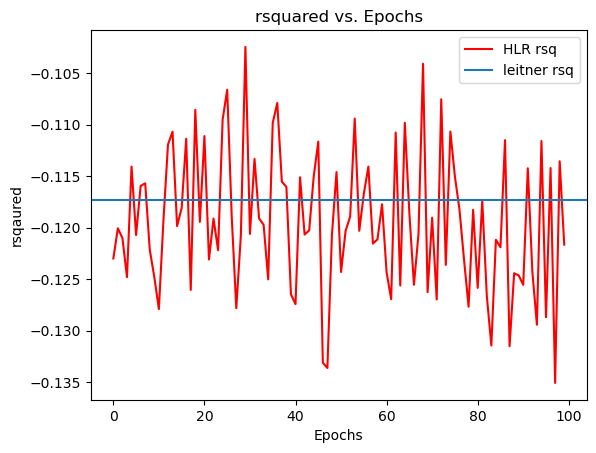

In [27]:
from utils import r_squared
plt.plot(range(num_epochs), epoch_metrics_df['batch_training_rsq'],color = 'red',label = "HLR rsq")
plt.axhline(y = r_squared(torch.tensor(df['p_recall']),leitner_predicted_p_recall).detach().item(),label = "leitner rsq")
plt.xlabel('Epochs')
plt.ylabel('rsqaured')
plt.title('rsquared vs. Epochs')
plt.legend()
plt.show()

In [ ]:
predictions = hlr.predict()

In [ ]:
# there's some error - we've made a mistake

# maybe, our features just don't have enough information, and it's impossible to learn

In [ ]:
# with this really bad result, we decide to peak at the work of duolingo

# observations

# they don't let half life be smaller than 15 minutes, or greater than 274 days (9 months)
# they clip half - life



In [ ]:
predicted_h_hat = model.forward(x)
predicted_p_recall = model.prediction(predicted_h_hat.squeeze(),delta)

plt.figure()
plt.hist(predicted_p_recall.detach().numpy(),color = "red",alpha = .3,label = 'predicted')
plt.hist(p.detach().numpy(),color = "blue",alpha = .3,label = 'observed')
plt.legend()
plt.show()

In [ ]:
# observations
# model overestimates p_recall 


In [ ]:
print(f"mean absolute percentage error: {mean_absolute_percentage_error(torch.tensor(simple_df['p_recall']),predicted_p_recall)}")

In [ ]:
print(f"r-squared: {r_squared(torch.tensor(simple_df['p_recall']),predicted_p_recall)}")

In [ ]:
# it's going to be really important to compare our half-life model (when eventually we get it right)
# to whatever system is in deployment currently
# compare to what duolingo is using to predict when to show a user a vocab word
# leitner is the legacy system
# we need to beat leitner
# therefore we need build leitner, otherwise we can't do the comparison.
